In [21]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests as rq
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Access your API key
api_key = os.getenv("COINGECKO_API_KEY")

In [2]:
# Get full list of tokens of Solana blockchain
url = "https://api.coingecko.com/api/v3/token_lists/solana/all.json"

headers = {"x-cg-demo-api-key": api_key}

response = rq.get(url, headers=headers)

json_data = response.json()


In [3]:
# Convert json to pandas dataframe

df = pd.json_normalize(
    json_data,
    record_path=['tokens'],
    meta=['name', 'logoURI', 'keywords', 'timestamp'],
    record_prefix='token_'

)

# Rename the top-level 'name' to avoid confusion
df.rename(columns={'name': 'source_name'}, inplace=True)


# Show first 5 rows
df.head()


,token_chainId,token_address,token_name,token_symbol,token_decimals,token_logoURI,source_name,logoURI,keywords,timestamp
0,None,BWhsvkyrUJqVvrAKjGYLpnTuUCG4SPEh6xVKcjnYCi27,HmmOnSOL,HMM,9,https://assets.coingecko.com/coins/images/3722...,CoinGecko,https://static.coingecko.com/gecko-new.svg,[defi],2025-09-19T19:02:36.283+00:00
1,None,48TqCgU8zC2H5tWshNriY2bWHDULSTSvdgL4iP1Fpump,holo,HOLO,6,https://assets.coingecko.com/coins/images/6885...,CoinGecko,https://static.coingecko.com/gecko-new.svg,[defi],2025-09-19T19:02:36.283+00:00
2,None,D3S1AW1Tj1BbQVCo34D9frJDoD81dU8YRCPhbtUUpump,CAPY,CAPY,6,https://assets.coingecko.com/coins/images/5604...,CoinGecko,https://static.coingecko.com/gecko-new.svg,[defi],2025-09-19T19:02:36.283+00:00
3,None,HogxGo1jDwvseBdYNvNBM7UYpsWJPifbH7hM5nCvBWuw,Hog,HOG,9,https://assets.coingecko.com/coins/images/3775...,CoinGecko,https://static.coingecko.com/gecko-new.svg,[defi],2025-09-19T19:02:36.283+00:00
4,None,6fnYdoJhYkifvt52pfNtUDr31ZYXmof7JiL9SFrMpump,hit meeee upp,HMU,6,https://assets.coingecko.com/coins/images/3999...,CoinGecko,https://static.coingecko.com/gecko-new.svg,[defi],2025-09-19T19:02:36.283+00:00


In [4]:
# Retain only relevant columns for EDA
relevant_columns = [
    'token_address',
    'token_name',
    'token_symbol',
    'token_decimals',
    'timestamp'
]

# Create a new DataFrame with only the relevant columns
df = df[relevant_columns].copy()

# Show the columns of the new DataFrame to confirm
print("Columns after filtering:", df.columns)

# Display the first 5 rows of the new DataFrame
df.head()


Columns after filtering: Index(['token_address', 'token_name', 'token_symbol', 'token_decimals',
       'timestamp'],
      dtype='object')


,token_address,token_name,token_symbol,token_decimals,timestamp
0,BWhsvkyrUJqVvrAKjGYLpnTuUCG4SPEh6xVKcjnYCi27,HmmOnSOL,HMM,9,2025-09-19T19:02:36.283+00:00
1,48TqCgU8zC2H5tWshNriY2bWHDULSTSvdgL4iP1Fpump,holo,HOLO,6,2025-09-19T19:02:36.283+00:00
2,D3S1AW1Tj1BbQVCo34D9frJDoD81dU8YRCPhbtUUpump,CAPY,CAPY,6,2025-09-19T19:02:36.283+00:00
3,HogxGo1jDwvseBdYNvNBM7UYpsWJPifbH7hM5nCvBWuw,Hog,HOG,9,2025-09-19T19:02:36.283+00:00
4,6fnYdoJhYkifvt52pfNtUDr31ZYXmof7JiL9SFrMpump,hit meeee upp,HMU,6,2025-09-19T19:02:36.283+00:00


## Exploratory Data Analysis

In [5]:
# How many records are in the dataset
len(df)

5148

In [6]:
# What is the dimension of our dataset
df.shape

(5148, 5)

In [7]:
# Check for missing values
df.isnull().sum()

token_address     0
token_name        0
token_symbol      0
token_decimals    0
timestamp         0
dtype: int64

In [8]:
# Check for duplicates

df.duplicated().sum()

0

In [9]:
# Get summary statistics

df.describe()

,token_decimals
count,5148.000000
mean,6.763209
std,1.520046
min,0.000000
25%,6.000000
50%,6.000000
75%,8.000000
max,18.000000


### Get tokens prices from another endpoint

In [10]:
# Get all unique contract addresses from your DataFrame
contract_addresses = df['token_address'].tolist()


# Get only the first 100 addresses for testing
test_addresses = contract_addresses[:100] 

# Define the CoinGecko API endpoint
addresses_param = ",".join(test_addresses)


url = f"https://api.coingecko.com/api/v3/simple/token_price/solana?contract_addresses={addresses_param}&vs_currencies=usd&include_market_cap=true&include_24hr_vol=true&include_24hr_change=true"
headers = {"x-cg-demo-api-key": api_key} 


# --- 3. Make the API Call ---
response = rq.get(url, headers=headers)
response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
price_data = response.json()


# Convert the dictionary response directly into a DataFrame
df_prices = pd.DataFrame.from_dict(price_data, orient='index')

# Rename the index column to 'token_address' so it can be merged
df_prices.index.name = 'token_address'
df_prices = df_prices.reset_index()

# Rename columns to be more descriptive and consistent
df_prices = df_prices.rename(columns={
    'usd': 'price_usd',
    'usd_market_cap': 'market_cap_usd',
    'usd_24h_vol': '24h_volume_usd',
    'usd_24h_change': '24h_price_change_percentage'
})


# Define a list of desired columns
desired_cols = [
        'token_address',
        'price_usd',
        'market_cap_usd',
        '24h_volume_usd',
        '24h_price_change_percentage'
    ]

df_prices = df_prices[desired_cols]

print("\nNew price data DataFrame:")
df_prices.head()





New price data DataFrame:


,token_address,price_usd,market_cap_usd,24h_volume_usd,24h_price_change_percentage
0,BWhsvkyrUJqVvrAKjGYLpnTuUCG4SPEh6xVKcjnYCi27,0.000106,0.000000,1.201269e+02,-2.616395
1,48TqCgU8zC2H5tWshNriY2bWHDULSTSvdgL4iP1Fpump,0.000096,95481.502723,1.120161e+06,-8.715389
2,D3S1AW1Tj1BbQVCo34D9frJDoD81dU8YRCPhbtUUpump,0.000015,15125.093661,4.846567e+01,-6.403165
3,HogxGo1jDwvseBdYNvNBM7UYpsWJPifbH7hM5nCvBWuw,0.000008,0.000000,1.686757e+00,NaN
4,6fnYdoJhYkifvt52pfNtUDr31ZYXmof7JiL9SFrMpump,0.000037,36701.435160,2.279902e+02,-2.856205


In [11]:
# Merge df with the new price data on 'token_address'
df_merged = pd.merge(df, df_prices, on='token_address', how='right')

print("\nMerged DataFrame:")
df_merged.head()


Merged DataFrame:


,token_address,token_name,token_symbol,token_decimals,timestamp,price_usd,market_cap_usd,24h_volume_usd,24h_price_change_percentage
0,BWhsvkyrUJqVvrAKjGYLpnTuUCG4SPEh6xVKcjnYCi27,HmmOnSOL,HMM,9,2025-09-19T19:02:36.283+00:00,0.000106,0.000000,1.201269e+02,-2.616395
1,48TqCgU8zC2H5tWshNriY2bWHDULSTSvdgL4iP1Fpump,holo,HOLO,6,2025-09-19T19:02:36.283+00:00,0.000096,95481.502723,1.120161e+06,-8.715389
2,D3S1AW1Tj1BbQVCo34D9frJDoD81dU8YRCPhbtUUpump,CAPY,CAPY,6,2025-09-19T19:02:36.283+00:00,0.000015,15125.093661,4.846567e+01,-6.403165
3,HogxGo1jDwvseBdYNvNBM7UYpsWJPifbH7hM5nCvBWuw,Hog,HOG,9,2025-09-19T19:02:36.283+00:00,0.000008,0.000000,1.686757e+00,NaN
4,6fnYdoJhYkifvt52pfNtUDr31ZYXmof7JiL9SFrMpump,hit meeee upp,HMU,6,2025-09-19T19:02:36.283+00:00,0.000037,36701.435160,2.279902e+02,-2.856205


In [12]:
# What is the dimension of our new dataset
df_merged.shape

(97, 9)

In [13]:
# Summary statistics of the merged dataset
df_merged.describe()

,token_decimals,price_usd,market_cap_usd,24h_volume_usd,24h_price_change_percentage
count,97.000000,9.700000e+01,9.700000e+01,9.700000e+01,87.000000
mean,6.546392,5.465574e+00,9.584786e+06,8.045555e+05,-4.952620
std,1.587849,3.688227e+01,4.887158e+07,5.229092e+06,6.745070
min,0.000000,7.537950e-13,0.000000e+00,0.000000e+00,-34.768045
25%,6.000000,1.358000e-05,1.015411e+04,9.405241e+00,-6.394379
50%,6.000000,4.661000e-05,2.908209e+04,1.156245e+02,-5.114949
75%,6.000000,2.924800e-04,1.507136e+05,3.687753e+03,-2.640533
max,9.000000,2.709800e+02,4.068388e+08,4.432056e+07,21.327312


In [ ]:
# Get data types of columns
df_merged.dtypes

token_address                   object
token_name                      object
token_symbol                    object
token_decimals                   int64
timestamp                       object
price_usd                      float64
market_cap_usd                 float64
24h_volume_usd                 float64
24h_price_change_percentage    float64
dtype: object

In [ ]:
# Get row with highest market cap

df_merged[df_merged['market_cap_usd']== df_merged['market_cap_usd'].max()]

,token_address,token_name,token_symbol,token_decimals,timestamp,price_usd,market_cap_usd,24h_volume_usd,24h_price_change_percentage
75,Dso1bDeDjCQxTrWHqUUi63oBvV7Mdm6WaobLbQ7gnPQ,Drift Staked SOL,DSOL,9,2025-09-19T19:02:36.283+00:00,270.98,4.068388e+08,398148.509383,-5.116648


In [ ]:
# Get row with highest price

df_merged[df_merged['price_usd']== df_merged['price_usd'].max()]

,token_address,token_name,token_symbol,token_decimals,timestamp,price_usd,market_cap_usd,24h_volume_usd,24h_price_change_percentage
75,Dso1bDeDjCQxTrWHqUUi63oBvV7Mdm6WaobLbQ7gnPQ,Drift Staked SOL,DSOL,9,2025-09-19T19:02:36.283+00:00,270.98,4.068388e+08,398148.509383,-5.116648


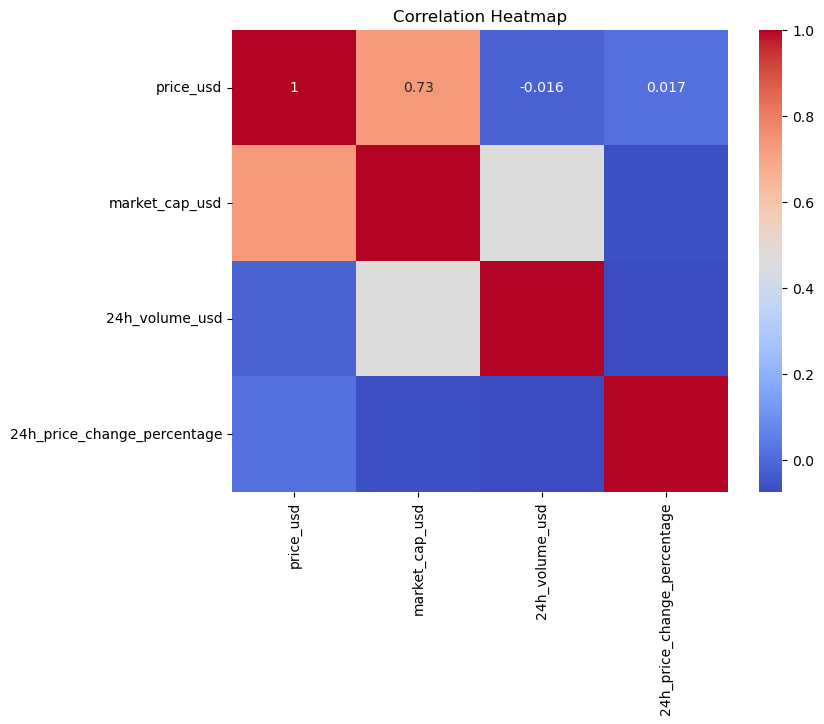

In [25]:
# Correlation analysis
df_merged = df_merged.drop(columns=['token_decimals'])
corr_matrix = df_merged.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


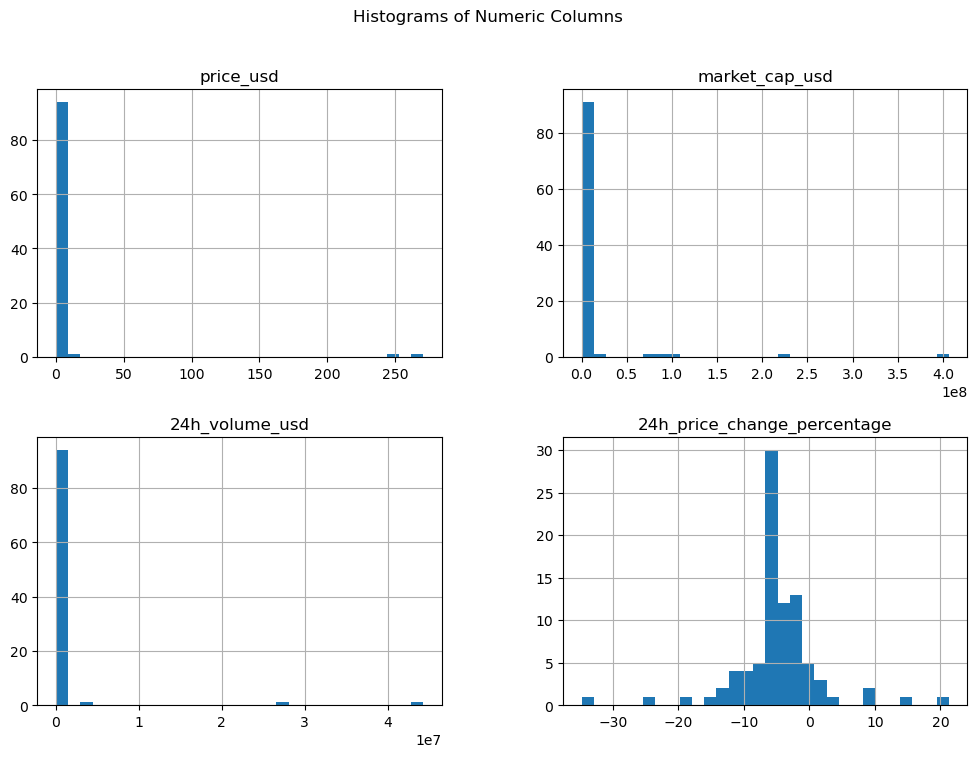

In [27]:
# Plot histogram for all numeric columns
df_merged.hist(figsize=(12, 8), bins=30)
plt.suptitle('Histograms of Numeric Columns')
plt.show()